<h1><center> Домашняя работа #2</center></h1>

Задача:

- реализуйте алгоритм DQN с реплей буффером и мягким обновлением целевой сети;
- обучите агента в среде Lunar Lander;

Описание задачи на сайте Gymnasium ([ссылка](https://gymnasium.farama.org/environments/box2d/lunar_lander/))

## Imports

In [1]:
import sys

sys.path.append("..")

In [ ]:
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from tqdm import trange

In [ ]:
%load_ext autoreload
%autoreload 2

from src.deep_q_learning import (
    DQN,
    ReplayMemory,
    select_action,
    optimize_model,
    soft_update,
)
from src.torch_utils import get_device

## Environment

**Observation space:**

The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

**Actions:**

- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

**Rewards:**

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

**Note** `pip install "gymnasium[box2d]"` fails horribly. Install `swig` and then `Box2D`. It's also in requirements

Source [Git](https://github.com/Farama-Foundation/Gymnasium/issues/1324#issuecomment-2700987713)

In [4]:
env = gym.make(
    "LunarLander-v3",
    continuous=False,  # Для DQN нужен дискретный набор действий
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5,
    max_episode_steps=1_000,
    # render_mode="human"  # Раскомментируйте, чтобы увидеть игру
)

C:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## Model

Вспомним, что в "классическом" Q-learning мы обновляем q-значения (награды) на сетке следующим образом:

$$\begin{align*}
Q(s, a) &\leftarrow Q(s, a) + \alpha \delta \\
\text{where } \delta &= R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a) \\
\\
\text{and } & s \text{ - current state} \\
& a \text{ - current action} \\
& s' \text{ - next state} \\
& \alpha \text{ - learning rate } (0 \leq \alpha \leq 1) \\
& \gamma \text{ - discount factor } (0 \leq \gamma \leq 1) \\
& R(s, a) \text{ - immediate reward}
\end{align*}$$

$\delta$ также известна temporal diffrence error. 

В Deep Q-learning (DQM) мы хотим обучить нейронную сеть для прогноза $Q^*$ путем минимазации $\delta$

Для этого нам нужно реализовать в PyTorch следующее:

1. Replay Buffer or Replay Memory - "хранилище" векторов $(s_j, a_j, r_j, s_j')$
2. Policy Network or Online Network - модель, которую DQN агент использует на каждом шаге для прогноза Q-значений и выбора действия (вместо выбора максимального значения как раньше).
3. Target network - более стабильная онлайн модель, которая используется для прогноза ожидаемых Q-значений



Источники:
- ["Reinforcement Learning (DQN) Tutorial"](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- ["Глубокое Q-обучение (DQN)"](https://habr.com/ru/articles/906594/)

In [5]:
device = get_device()

Используемое устройство: cpu


In [6]:
n_actions = env.action_space.n
state, _ = env.reset()
n_observations = len(state)

In [7]:
# Основные параметры RL
gamma = 0.9  # discount_factor
epsilon = 0.2  # probability of random action
epsilon_decay = 0.001  # eps_t = eps_t-1 * (1 - epsilon_decay)

# Основные параметры DL
lr = 1e-4
tau = 1e-3
exploratory_period = 100
n_epochs = 1_000
batch_size = 128

In [8]:
policy_net = DQN(n_observations, n_actions).to(device)

target_net = DQN(n_observations, n_actions).to(device)
# Policy weight sets have to be the same
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [19]:
optimizer = torch.optim.Adam(params=policy_net.parameters(), lr=lr, fused=True)

In [25]:
replay_memory = ReplayMemory(capacity=10_000, batch_size=batch_size)

In [26]:
assert(len(replay_memory.memory) == 0)

In [28]:
rewards = []

for num_episode in trange(n_epochs):

    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)

    exploratory_period_flag = num_episode < exploratory_period

    if num_episode == exploratory_period:
        print("Finished exploration. Starting to train model")

    done = False
    next_state = None
    total_reward = 0
    steps = 0

    while not done:

        action = select_action(
            n_actions=n_actions,
            epsilon=epsilon,
            state=state,
            policy_net=policy_net,
            exploratory_period=exploratory_period_flag,
            device=device,
        )

        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        # Perform one step of the optimization (on the policy network)
        if not exploratory_period_flag:
            optimize_model(
                optimizer=optimizer,
                criterion=torch.nn.MSELoss(),
                train_sample=replay_memory.sample(),
                policy_net=policy_net,
                target_net=target_net,
                gamma=gamma,
                verbose=((num_episode % 100 == 0) & done),
            )

        reward = torch.tensor([reward], device=device)
        next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        replay_memory.push(state, action, next_state, reward, terminated)

        state = next_state
        total_reward += reward
        steps += 1

    if reward == -100:
        rewards.append((steps, total_reward, 0, 1))
    elif reward == 100:
        rewards.append((steps, total_reward, 1, 0))
    else:
        rewards.append((steps, total_reward, 0, 0))

    # Using soft updates to update target policy
    # Hard updates would mean completely re-defining weights every n steps
    soft_update(target_net=target_net, policy_net=policy_net, tau=tau)

    if not exploratory_period_flag:
        epsilon *= 1 - epsilon_decay

  9%|███████                                                                        | 90/1000 [00:00<00:08, 106.54it/s]

Finished exploration. Starting to train model


 10%|███████▉                                                                       | 101/1000 [00:01<00:15, 59.73it/s]

Loss function value: 169.17453002929688


 20%|███████████████▉                                                               | 202/1000 [00:27<02:51,  4.65it/s]

Loss function value: 158.08628845214844


 30%|███████████████████████▊                                                       | 302/1000 [00:52<02:45,  4.21it/s]

Loss function value: 230.8032989501953


 40%|███████████████████████████████▋                                               | 401/1000 [01:19<03:10,  3.14it/s]

Loss function value: 156.437255859375


 50%|███████████████████████████████████████▌                                       | 501/1000 [01:57<02:55,  2.84it/s]

Loss function value: 86.2137222290039


 60%|███████████████████████████████████████████████▍                               | 601/1000 [02:31<02:13,  3.00it/s]

Loss function value: 156.62631225585938


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [03:02<01:24,  3.52it/s]

Loss function value: 154.00892639160156


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [03:34<00:54,  3.65it/s]

Loss function value: 229.50592041015625


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [04:06<00:30,  3.25it/s]

Loss function value: 4.84999942779541


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.60it/s]


In [29]:
torch.save(policy_net.state_dict(), "hw_2_trained_agent.pickle")

## Training graphs

In [30]:
table = pd.DataFrame(rewards, columns=["reward", "steps", "failure", "success"])
# table = table.iloc[2_000:, :]  # remove exploratory_period

In [31]:
table

,reward,steps,failure,success
0,91,"[tensor(-132.6621, dtype=torch.float64)]",0,1
1,95,"[tensor(-139.5052, dtype=torch.float64)]",0,1
2,102,"[tensor(-108.9474, dtype=torch.float64)]",0,1
3,99,"[tensor(-248.8468, dtype=torch.float64)]",0,1
4,98,"[tensor(-382.1477, dtype=torch.float64)]",0,1
...,...,...,...,...
995,50,"[tensor(-126.7480, dtype=torch.float64)]",0,1
996,72,"[tensor(-126.7835, dtype=torch.float64)]",0,1
997,60,"[tensor(-105.8382, dtype=torch.float64)]",0,1
998,91,"[tensor(-202.6267, dtype=torch.float64)]",0,1


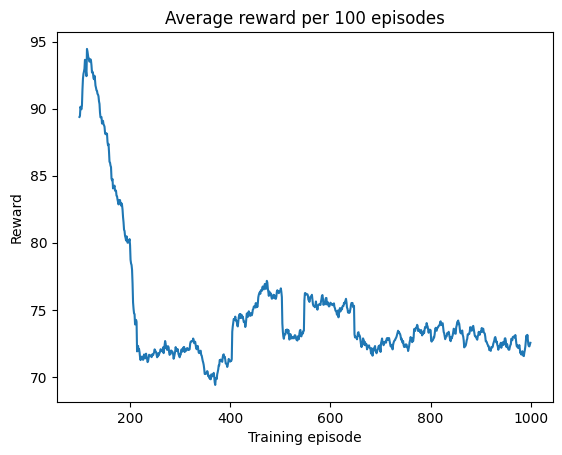

In [32]:
plt.plot(table.index, table["reward"].rolling(100).mean())
plt.xlabel("Training episode")
plt.ylabel("Reward")
plt.title("Average reward per 100 episodes")
plt.show()

## Анимация

In [33]:
policy_net = DQN(n_observations, n_actions).to(device)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [22]:
policy_net.load_state_dict(torch.load("hw_2_trained_agent.pickle"))

<All keys matched successfully>

In [23]:
env = gym.make(
    "LunarLander-v3",
    continuous=False,  # Для DQN нужен дискретный набор действий
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5,
    max_episode_steps=1_000,
    render_mode="human",  # Раскомментируйте, чтобы увидеть игру
)

In [24]:
# https://github.com/openai/gym/issues/741#issuecomment-778703878
done = False
score = 0
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device)

while not done:
    env.render()  # Раскомментируйте, чтобы увидеть игру
    with torch.no_grad():
        # best action
        action = policy_net(state).argmax()
    next_state, reward, terminated, truncated, info = env.step(action.item())
    done = terminated or truncated
    state = next_state
    state = torch.tensor(state, dtype=torch.float32, device=device)
    score += reward

env.close()

print(f"Score is: {score}")

Score is: -136.65118507122705
